## Keras example of supervised learning a NeuroGym task

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neurogym/neurogym/blob/master/examples/example_neurogym_keras.ipynb)


NeuroGym is a comprehensive toolkit that allows training any network model on many established neuroscience tasks using Reinforcement Learning techniques. It includes working memory tasks, value-based decision tasks and context-dependent perceptual categorization tasks.

In this notebook we first show how to install the relevant toolbox. 

We then show how to access the available tasks and their relevant information.

Finally we train an LSTM network on the Random Dots Motion task using standard supervised learning techniques (with Keras), and plot the results.

### Installation when used on Google Colab

In [ ]:
%tensorflow_version 1.x
# Install gymnasium
! pip install gymnasium
# Install neurogym
! git clone https://github.com/gyyang/neurogym.git
%cd neurogym/
! pip install -e .

### Task, network, and training

In [1]:
import warnings

import numpy as np
import neurogym as ngym

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Input

warnings.filterwarnings('ignore')
warnings.filterwarnings('default')

# Environment
task = 'PerceptualDecisionMaking-v0'
kwargs = {'dt': 100}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)
env = dataset.env
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n

# Model 
num_h = 64
# from https://www.tensorflow.org/guide/keras/rnn
xin = Input(batch_shape=(None, None, obs_size), dtype='float32')
seq = LSTM(num_h, return_sequences=True, time_major=True)(xin)
mlp = TimeDistributed(Dense(act_size, activation='softmax'))(seq)
model = Model(inputs=xin, outputs=mlp)
model.summary()
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train network
steps_per_epoch = 2000
data_generator = (dataset() for i in range(steps_per_epoch))
history = model.fit(data_generator, steps_per_epoch=steps_per_epoch)

/Users/gryang/tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/gryang/tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/gryang/tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/gryang/tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/Users/gryang/tf1/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/gryang/tf1/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/gryang/tf1/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/gryang/tf1/lib/python3.7/site-packages/tensorboard/compat/tensorflow_

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 3)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          17408     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 3)           195       
Total params: 17,603
Trainable params: 17,603
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
   7/2000 [..............................] - ETA: 5:35 - loss: 1.0581 - acc: 0.4196

/Users/gryang/Dropbox/Code/MyPython/neurogym/neurogym/core.py:253: UserWarning: Warning: Time for period fixation 100.000000  lasts only one timestep. Agents will not have time to respond (e.g. make a choice) on time.
  ' time to respond (e.g. make a choice) on time.')
/Users/gryang/Dropbox/Code/MyPython/neurogym/neurogym/core.py:253: UserWarning: Warning: Time for period decision 100.000000  lasts only one timestep. Agents will not have time to respond (e.g. make a choice) on time.
  ' time to respond (e.g. make a choice) on time.')


2000/2000 [==============================] - 106s 53ms/step - loss: 0.0569 - acc: 0.9835


### Analysis

In [2]:
perf = 0
num_trial = 200
for i in range(num_trial):
    env.new_trial()
    obs, gt = env.obs, env.gt
    obs = obs[:, np.newaxis, :]

    action_pred = model.predict(obs)
    action_pred = np.argmax(action_pred, axis=-1)
    perf += gt[-1] == action_pred[-1, 0]

perf /= num_trial
print(perf)

0.895


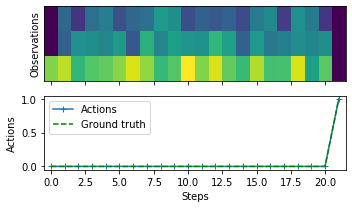

In [3]:
_ = ngym.utils.plotting.fig_(obs[0], action_pred[0], gt)